In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head(10)
df.drop(columns=['id','Residence_type'],axis=1,inplace=True)
df = df[df['gender'] != 'Other']
df = df[df['age'] >= 1]
# Define a threshold for outlier detection
bmi_threshold = 50

# Filter out records with 'bmi' values beyond the threshold
df = df[df['bmi'] <= bmi_threshold]
from sklearn.model_selection import train_test_split

# Splitting the DataFrame into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Calculate the median of the 'bmi' column in the training set
train_median_bmi = train_df['bmi'].median()

# Fill missing values in the training set
train_df['bmi'].fillna(train_median_bmi, inplace=True)

# Fill missing values in the test set using the median from the training set
test_df['bmi'].fillna(train_median_bmi, inplace=True)
from sklearn.preprocessing import LabelEncoder

label_encode_cols = ['smoking_status', 'work_type']
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding for each column in training and test sets
for col in label_encode_cols:
    train_df[col] = label_encoder.fit_transform(train_df[col])
    test_df[col] = label_encoder.transform(test_df[col])
# Columns to one-hot encode
onehot_cols = ['gender','ever_married']

# Apply one-hot encoding to training set
train_df_onehot = pd.get_dummies(train_df, columns=onehot_cols)

# Apply one-hot encoding to test set
test_df_onehot = pd.get_dummies(test_df, columns=onehot_cols)

# Scaler -> min max scaler
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Columns to scale
scale_cols = ['age', 'bmi','avg_glucose_level']

# Fit the scaler on the training data and transform both training and test data.
scaler.fit(train_df_onehot[scale_cols])

train_df_onehot[scale_cols] = scaler.transform(train_df_onehot[scale_cols])
test_df_onehot[scale_cols] = scaler.transform(test_df_onehot[scale_cols])

X_train = train_df_onehot.drop('stroke',axis=1)
y_train = train_df_onehot['stroke']

X_test = test_df_onehot.drop('stroke',axis=1)
y_test = test_df_onehot['stroke']

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Define the hyperparameters grid for Naive Bayes
param_grid = {
    'priors': [None, [0.5, 0.5], [0.7, 0.3], [0.3, 0.7]],  # Different types of priors
}

# Create the Naive Bayes model
naive_bayes = GaussianNB()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Score:", best_score)
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_


Best Score: 0.859227631870851
Best Hyperparameters: {'priors': None}


In [5]:
naive_bayes=GaussianNB(priors=None)
naive_bayes.fit(X_train,y_train)
print(naive_bayes.score(X_test,y_test))

0.8507306889352818


In [6]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)


In [7]:
naive_bayes.fit(X_train_resampled, y_train_resampled)
accuracy = naive_bayes.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6492693110647182


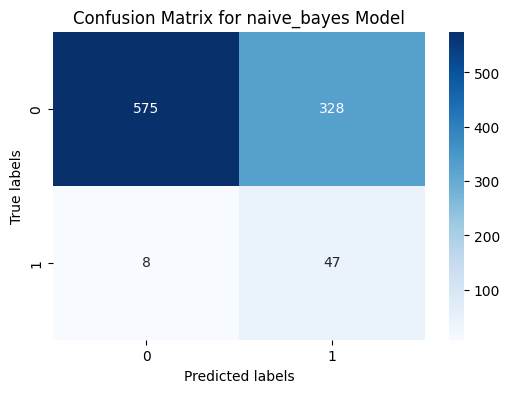

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = naive_bayes.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for naive_bayes Model')
plt.show()
